# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

# Proposed solution

We will start with importing needed packages :

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [11]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Approach

We start pipeline development assuming that test images and videos have enought gradient information to detect lines. **Depending on the results we could use the lines color information as well.** 

The entry point for our pipeline is the function process_image defined below. 


In [70]:
# We need statistics package to get median
import statistics
# Constants
# edge detection:
BLUR = 3
CANNY_LOW = 150
CANNY_HIGH = 200
# Hough transform
RHO = 2
THETA = np.pi/180
THRESHOLD = 15
MIN_LINE_LEN = 40
MAX_LINE_GAP = 30
# region of interest
MARGIN_BOTTOM = 40
MARGIN_TOP = 40
INFINITY_POINT = [.5, .6]
# left and right lines coefficients (slop and offset)
ML = 0.6
BL = 16
MR = -0.73
BR = 658
# error threashhold to filter lane lines segments only
M_ERR = .07
B_ERR = 500

# This is our pipeline.
def process_image(image):
    # get edges from a bluried grayscale image 
    edges = canny(gaussian_blur(grayscale(image), BLUR), CANNY_LOW, CANNY_HIGH)
    
    # define region of interest   
    h = image.shape[0]
    w = image.shape[1]
    vertices = np.array([ \
            [(0 + MARGIN_BOTTOM , h), \
             (w * INFINITY_POINT[0] - MARGIN_TOP, h * INFINITY_POINT[1]), \
             (w * INFINITY_POINT[0] + MARGIN_TOP, h * INFINITY_POINT[1]), \
             (w - MARGIN_BOTTOM, h)] \
        ], dtype=np.int32)
    
    # get edges from the region of interest
    cliped_edges = region_of_interest(edges, vertices)
    
    # get hough lines from the clipped edges
    lines = hough_averaged_lines(cliped_edges, RHO, THETA, THRESHOLD, MIN_LINE_LEN, MAX_LINE_GAP)
    
    # draw lines on top of image
    combo = weighted_img(image, lines,0.8, 1, 0)
    result = combo
    return result

# This function takes the output of a Canny transform producing ough hlines.        
# Returns an image with hough lines drawn with averaged lines for both left and right.
def hough_averaged_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_averaged_lines(line_img, lines)
    return line_img

# This function draws left and rihgt averaged lines by retrieveing 
# line coefficients from every hough line segment and taking median value.
# For both left and right lines we'll draw straight lines from 
# the bottom to the 0.6 (0.65 for the challenge video) of image height.
def draw_averaged_lines(img, lines, color=[255, 0, 0], thickness=2):
    # y = m*x + b
    # collections for accumulating slope coefficiens for left and right lines
    m_right = []
    m_left = []
    b_left = []
    b_right = []    
    # draw hought lines and collect coefficiens
    for line in lines:
        for x1,y1,x2,y2 in line:
            x = [x1, x2]
            y = [y1, y2]
            # calculate line coefficients
            mb = np.polyfit(x, y, 1)
            if (mb[0] > 0):
                # check if line is close to left line   
                if (abs(mb[0] - ML) < M_ERR):
                    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                    m_left.append(mb[0])
                    b_left.append(mb[1])
            else:
                # check if line is close to right line   
                if (abs(mb[0] - MR) < M_ERR):
                    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                    m_right.append(mb[0])
                    b_right.append(mb[1])    
    if (challenge_output == 'extra.mp4'):
        # challenge movie has different dimensions then others
        h = 714
        w = 1269
        T = int(h * .65)
    else:
        h = image.shape[0]
        w = image.shape[1]
        T = int(h * .6)
    # get median from both left and right collections and draw averaged lines
    # left line
    if (len(m_left) > 0):
        ml = statistics.median(m_left)
        bl = statistics.median(b_left)
        A = [int((h - bl) / ml), h]
        B = [int((T - bl) / ml), T]
        cv2.line(img, (A[0], A[1]), (B[0], B[1]), color, thickness * 5)
    # right line
    if (len(m_right) > 0):
        mr = statistics.median(m_right)
        br = statistics.median(b_right)
        C = [int((h - br) / mr), h]
        D = [int((T - br) / mr), T]
        cv2.line(img, (C[0], C[1]), (D[0], D[1]), color, thickness * 5)


## Test on Images

We will make sure our pipeline works well on the test images before trying the videos. Every change on the pipeline we'll be testing by running the code below:

Image: solidWhiteCurve.jpg


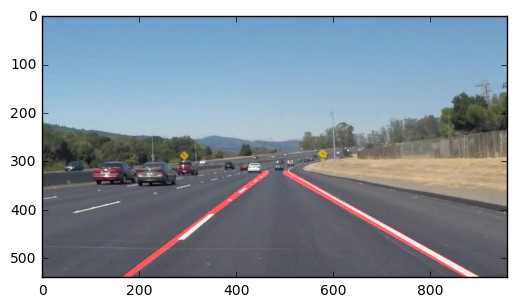

Image: solidWhiteRight.jpg


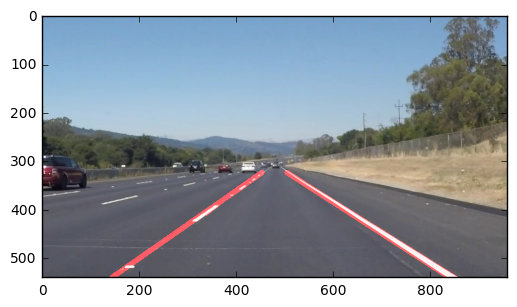

Image: solidYellowCurve.jpg


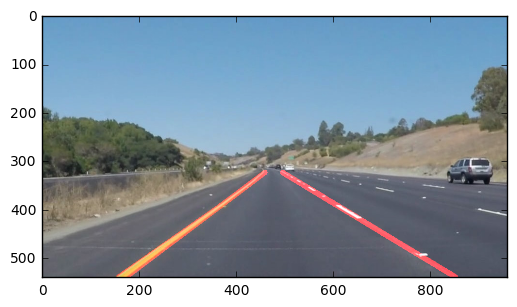

Image: solidYellowCurve2.jpg


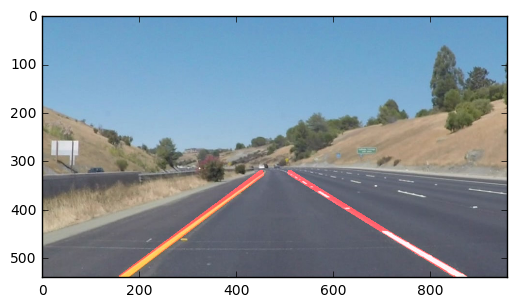

Image: solidYellowLeft.jpg


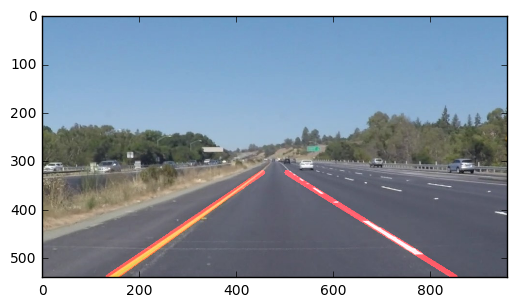

Image: whiteCarLaneSwitch.jpg


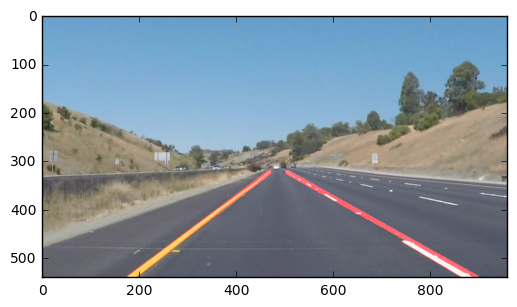

In [71]:
# Not a challlenge yet
challenge_output = 'none'

import os

files = os.listdir("test_images/")
for file in files:
    image = mpimg.imread("test_images/" + file)
    print('Image:', file)
    proc_image = process_image(image)
    plt.imshow(proc_image)
    plt.show()
    mpimg.imsave("processed_" + file, proc_image)

## Test on Videos

Now we test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [72]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [73]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:02<00:00, 81.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.26 s, sys: 784 ms, total: 3.04 s
Wall time: 3.13 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [66]:
HTML("""
<video width="1269" height="714" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [67]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:09<00:00, 73.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 7.93 s, sys: 1.85 s, total: 9.77 s
Wall time: 9.67 s


In [68]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

### Making our algorithm better / more robust  
Proposed algorithm is based on assumption that a more then one hough line will be detected so we could average and extrapolate it. We currently use only gradient information and the algorithm will fail in case when the line gradient is not strong anough. 

To make the algorithm better we need to use color information and retry diffrent thresholds if lines are not detected.
Temporal processing of video frames will definitely help to keep line overlays stable.  


## Optional Challenge

Our lane finding pipeline needs special detection of the image size to run on the video below. We use challenge_output variable to detect the condition and use dimenions w=714, h=1269 and horizon line: h * 0.65. 

In [74]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)
challenge_output = 'none'

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:06<00:00, 38.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 4.64 s, sys: 1.29 s, total: 5.93 s
Wall time: 7.25 s


In [61]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))